
# Dynamic Time Warping

In [2]:
# Code source: Stefan Balke
# License: ISC
# sphinx_gallery_thumbnail_number = 4

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time

import librosa

## Load Audio Recordings
First, let's load a first version of our audio recordings.



In [3]:
audio_1 = 'audio/MamboFestival-120.mp3'
audio_2 = 'audio/MamboFestival-150.mp3'

x_1, fs = librosa.load(audio_1)
x_2, fs = librosa.load(audio_2)

C:\Users\sarag\AppData\Local\Temp\ipykernel_23696\2017852855.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  x_1, fs = librosa.load(audio_1)
c:\Users\sarag\Desktop\TFG\MetronIA\.conda\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\sarag\AppData\Local\Temp\ipykernel_23696\2017852855.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  x_2, fs = librosa.load(audio_2)
c:\Users\sarag\Desktop\TFG\MetronIA\.conda\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


[Text(0.5, 1.0, 'Audio 2')]

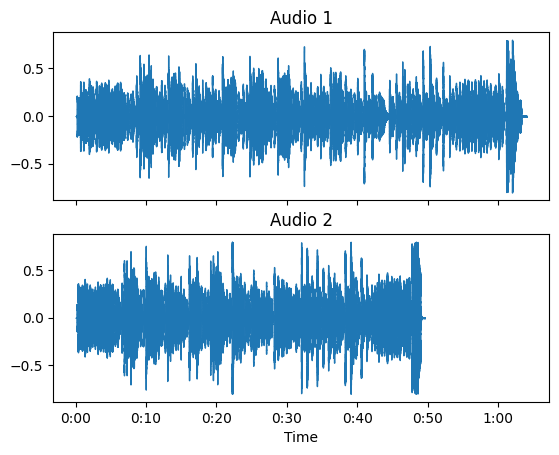

In [4]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
librosa.display.waveshow(x_1, sr=fs, ax=ax[0])
ax[0].set(title='Audio 1')
ax[0].label_outer()

librosa.display.waveshow(x_2, sr=fs, ax=ax[1])
ax[1].set(title='Audio 2')

## Extract Chroma Features



In [85]:
hop_length = 1024

x_1_chroma = librosa.feature.chroma_cqt(y=x_1, sr=fs,
                                         hop_length=hop_length)
x_2_chroma = librosa.feature.chroma_cqt(y=x_2, sr=fs,
                                         hop_length=hop_length)

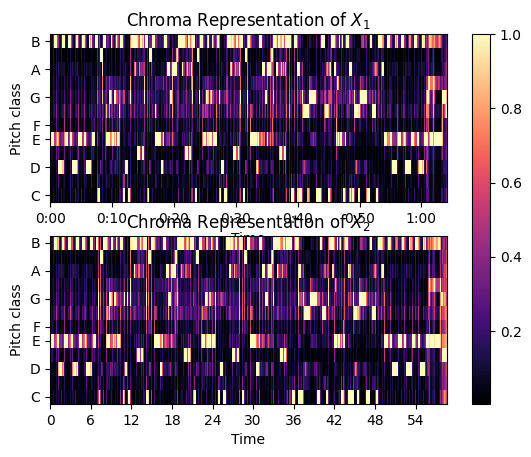

In [65]:
fig, ax = plt.subplots(nrows=2, sharey=True)
img = librosa.display.specshow(x_1_chroma, x_axis='time',
                               y_axis='chroma',
                               hop_length=hop_length, ax=ax[0])
ax[0].set(title='Chroma Representation of $X_1$')
librosa.display.specshow(x_2_chroma, x_axis='time',
                         y_axis='chroma',
                         hop_length=hop_length, ax=ax[1])
ax[1].set(title='Chroma Representation of $X_2$')
fig.colorbar(img, ax=ax)

## Different DTW parameters
https://librosa.org/doc/latest/generated/librosa.sequence.dtw.html#librosa-sequence-dtw

librosa.sequence.dtw Returns:
- D: np.ndarray [shape=(N, M)]  
accumulated cost matrix. The value at the final index position D[-1, -1] is the total alignment cost.

- wp: np.ndarray [shape=(L, 2)]  
Warping path with index pairs. Each row of the array contains an index pair (n, m). Only returned when backtrack is True. Note that the length L of the warping path need not match the lengths of the input data, depending on the step_sizes_sigma values and subseq.

- steps: np.ndarray [shape=(N, M)]  
Step matrix, containing the indices of the used steps from the cost accumulation step. Only returned when return_steps is True.

### Metrics
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html

The distance metric to use. If a string, the distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulczynski1’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

In [66]:
metrics = [ 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard',
           'jensenshannon', # Este tarda más en calcularse que los demás
        #    'kulczynski1', # Este produce un fallo
           'mahalanobis', 
           'matching', 
           'minkowski', 
           'rogerstanimoto', 
           'russellrao', 
           'seuclidean', 
           'sokalmichener', 
           'sokalsneath', 
           'sqeuclidean', 
           'yule']

In [86]:
show_messages = False
dtw_results = []

for m in metrics:
    start_time = time.perf_counter()
    D, wp, steps = librosa.sequence.dtw(X=x_1_chroma, Y=x_2_chroma,
                                        metric=m, 
                                        backtrack=True,
                                        return_steps=True)
    elapsed_time = time.perf_counter() - start_time  # Tiempo en segundos
    # Convertir tiempo a ms
    elapsed_time *= 1000  # Convertir a milisegundos

    
    if show_messages:
        print(f"DTW distance ({m}): {D[-1, -1]:.2f}")
        print(f"DTW path length ({m}): {len(wp)}")
        print(f"DTW steps length ({m}): {len(steps)}")
        print(f"Execution time ({m}): {elapsed_time:.4f} s")
        print("---" * 20)

    dtw_results.append({
        'metric': m,
        'distance': D[-1, -1],
        'wp': wp,
        'steps': steps,
        'execution_time': elapsed_time
    })

In [87]:
# Convertir a DataFrame
df_dtw = pd.DataFrame(dtw_results)

# Añadir columnas con las longitudes
df_dtw['len_steps'] = df_dtw['steps'].apply(len)
df_dtw['len_wp'] = df_dtw['wp'].apply(len)

In [81]:
print(df_dtw[['metric', 'distance', 'len_steps', 'len_wp', 'execution_time']])

            metric      distance  len_steps  len_wp  execution_time
0       braycurtis  0.000000e+00       1381    1381         78.0844
1         canberra  0.000000e+00       1381    1381         88.5372
2        chebyshev  0.000000e+00       1381    1381         67.5248
3        cityblock  0.000000e+00       1381    1381         74.9397
4      correlation  4.651834e-14       1381    1381         80.8297
5           cosine  6.372680e-14       1381    1381         78.6568
6             dice  5.473599e+02       1381    1381         88.8516
7        euclidean  0.000000e+00       1381    1381         77.2228
8          hamming  0.000000e+00       1381    1381         71.3553
9          jaccard  0.000000e+00       1381    1381        109.3575
10   jensenshannon  0.000000e+00       1381    1381       4052.1533
11     mahalanobis  0.000000e+00       1381    1381        243.8052
12        matching  0.000000e+00       1381    1381         67.5515
13       minkowski  0.000000e+00       1381    1

In [82]:
def print_sorted_by(df, column_name, ascending=True):
    sorted_df = df.sort_values(by=column_name, ascending=ascending)
    print(f"Sorted by {column_name}:")
    print(sorted_df[['metric', column_name]])
    print("\n")

In [88]:
print_sorted_by(df_dtw, 'distance', False)

Sorted by distance:
            metric     distance
1         canberra  2297.485216
11     mahalanobis  1639.354923
16      seuclidean  1399.578223
8          hamming  1277.000000
12        matching  1277.000000
3        cityblock   769.184608
6             dice   569.592592
13       minkowski   333.698885
7        euclidean   333.698885
2        chebyshev   235.483682
19     sqeuclidean   135.422667
0       braycurtis   124.395089
10   jensenshannon   122.923898
4      correlation    56.187209
5           cosine    27.152114
9          jaccard     0.000000
14  rogerstanimoto     0.000000
15      russellrao     0.000000
17   sokalmichener     0.000000
18     sokalsneath     0.000000
20            yule     0.000000




In [72]:
print_sorted_by(df_dtw, 'len_wp', False)

Sorted by len_wp:
            metric  len_wp
19     sqeuclidean    1449
5           cosine    1440
4      correlation    1439
2        chebyshev    1433
13       minkowski    1418
7        euclidean    1418
3        cityblock    1416
0       braycurtis    1415
16      seuclidean    1414
1         canberra    1411
11     mahalanobis    1405
10   jensenshannon    1397
6             dice    1383
12        matching    1381
9          jaccard    1381
8          hamming    1381
14  rogerstanimoto    1381
15      russellrao    1381
17   sokalmichener    1381
18     sokalsneath    1381
20            yule    1381




In [73]:
print_sorted_by(df_dtw, 'execution_time', False)

Sorted by execution_time:
            metric  execution_time
10   jensenshannon       3655.5175
11     mahalanobis        225.0457
20            yule        146.2314
16      seuclidean        103.3665
18     sokalsneath         99.6515
15      russellrao         97.7150
9          jaccard         97.6401
13       minkowski         78.9094
1         canberra         75.7749
17   sokalmichener         75.0390
19     sqeuclidean         74.3474
14  rogerstanimoto         73.7517
6             dice         70.3634
4      correlation         70.0320
12        matching         68.9924
3        cityblock         68.5890
0       braycurtis         66.4868
7        euclidean         66.2821
5           cosine         61.8395
8          hamming         60.6754
2        chebyshev         57.9609




### Step Sizes
- step_sizes_sigma: np.ndarray [shape=[n, 2]]
Specifies allowed step sizes as used by the DTW.

### Weights
- weights_add: np.ndarray [shape=[n, ]]
Additive weights to penalize certain step sizes.

- weights_mul: np.ndarray [shape=[n, ]]
Multiplicative weights to penalize certain step sizes.